In [505]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [506]:
DATA_PATH = Path('')
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')

# Sort data by date for rolling windows + other time-based operations
train = train.sort_values(by="date")

In [507]:
# Plotting utility functions

def plot_pm2_5_emissions_city():
    # Plotting emissions over time for each city
    for city in train["city"].unique():
        print(train[train["city"] == "Lagos"]["date"])
        city_rows = train[train["city"] == city]
        print(city, city_rows.shape)
        plt.figure(figsize=(10, 6))
        plt.plot(city_rows["date"], city_rows["pm2_5"])
        plt.title(f'PM2.5 Emissions Over Time ({city})')
        plt.xlabel('Date')
        plt.ylabel('PM2.5 Emissions')
        plt.show()


def plot_pm2_5_emissions_city_scatter():
    plt.figure(figsize=(10,6))
    for city in train['city'].unique():
        plt.scatter([city]*len(train[train['city']==city]), train[train['city']==city]['pm2_5'])
    plt.xlabel('City')
    plt.ylabel('pm2.5 Emissions')
    plt.title('pm2.5 Emissions for Each City')
    plt.xticks(rotation=90)
    plt.show()

In [508]:
print(train.columns)
print(train["city"])
print(train["city"].value_counts())

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'city', 'country',
       'date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_densi

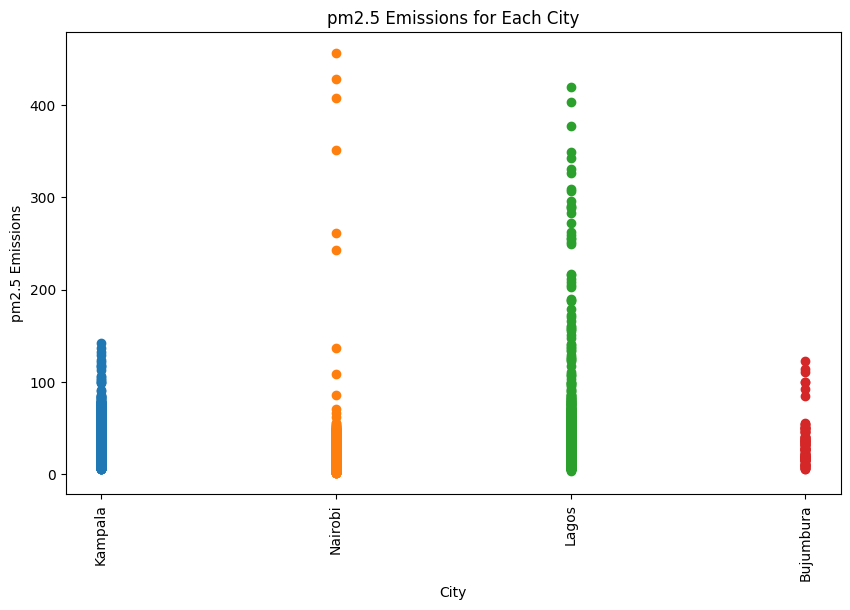

In [509]:
# Plotting pm2.5 emissions for each city (Comparison with all cities in one plot)
plot_pm2_5_emissions_city_scatter()

Lagos and Nairobi appear to have significantly more "outlier" emissions than Kampala and Bujumbura.

Simply removing them by using a threshold would not be the best as it could leave gaps in the data in terms of dates. A better approach would be to use a sliding window and attempting to detect outliers.

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Kampala (5596, 80)


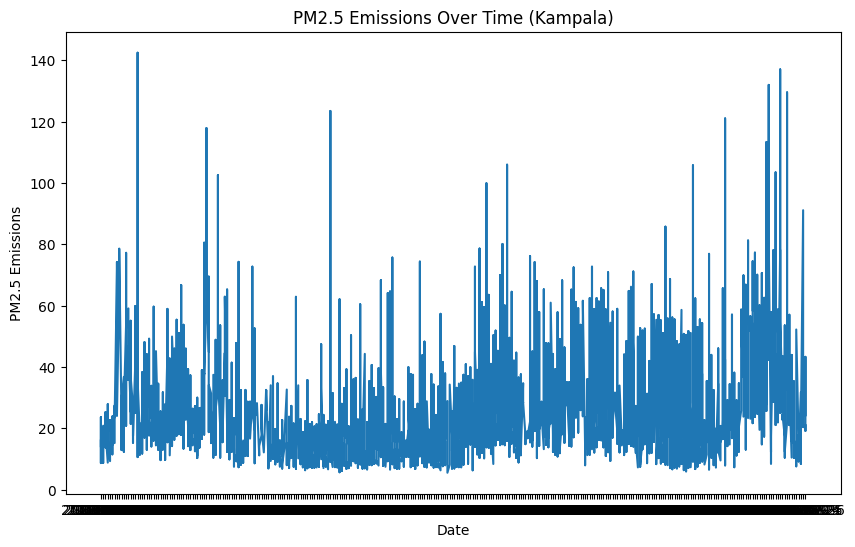

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Nairobi (1500, 80)


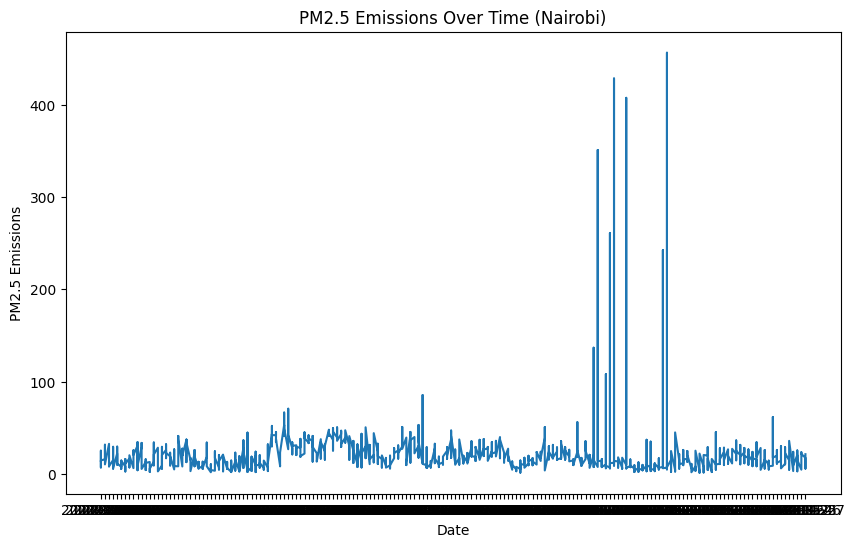

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Lagos (852, 80)


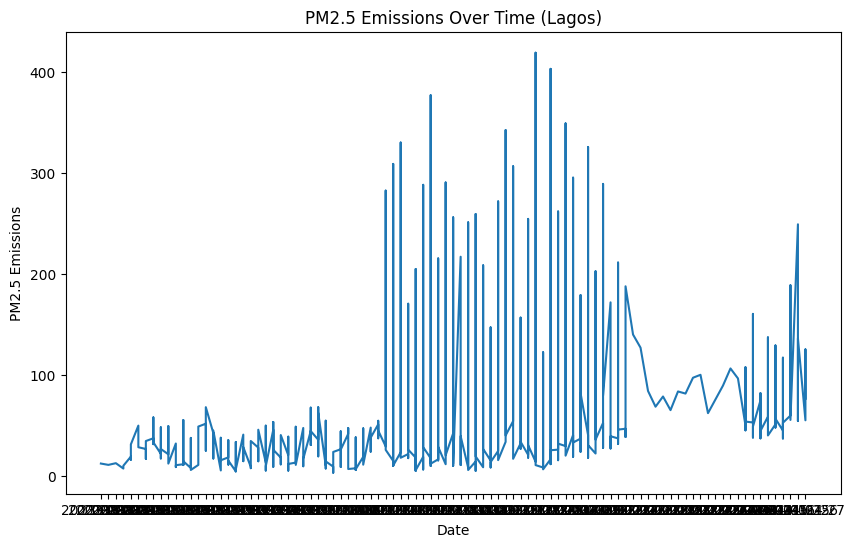

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 852, dtype: object
Bujumbura (123, 80)


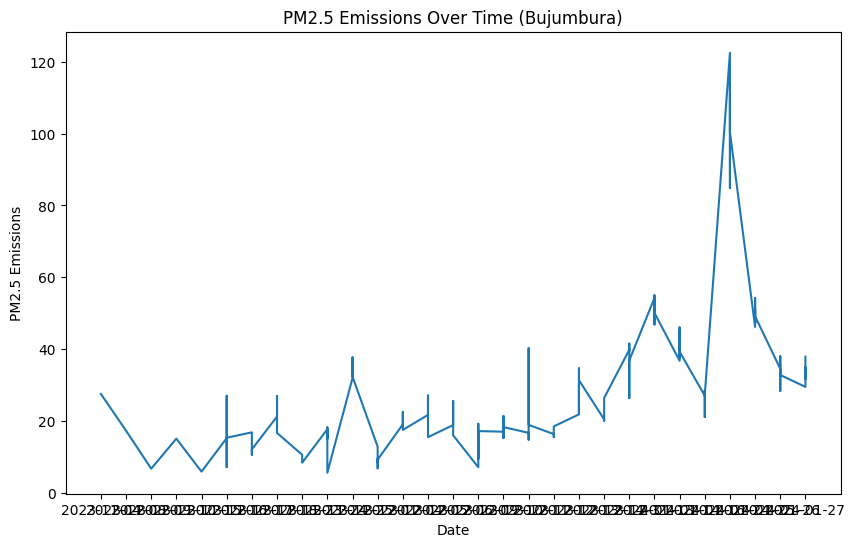

In [510]:
# Plotting pm2.5 emissions for each city
plot_pm2_5_emissions_city()

Clearly, some cities have more outliers than others. For example, the city of Lagos has a lot of outliers in the pm2.5 emissions.
Cities like Lagos and Nairobi should have handling for outliers.

In [511]:
city_stats = {}
for city in train["city"].unique():
    city_rows = train[train["city"] == city]
    std = city_rows["pm2_5"].std()
    median = city_rows["pm2_5"].median()
    mean = city_rows["pm2_5"].mean()
    print(f"City: {city} | Pm2.5 median| {median} | Pm2.5 mean | {mean} | Pm2.5 Std {std}")

    city_stats[city] = {"mean": mean, "median": median, "std": std}

City: Kampala | Pm2.5 median| 18.13490000000001 | Pm2.5 mean | 22.765383909098915 | Pm2.5 Std 14.34682858151784
City: Nairobi | Pm2.5 median| 15.275129411764706 | Pm2.5 mean | 18.87932986637841 | Pm2.5 Std 24.982218437683237
City: Lagos | Pm2.5 median| 33.43527307692308 | Pm2.5 mean | 46.213293731406935 | Pm2.5 Std 52.84388334184577
City: Bujumbura | Pm2.5 median| 26.352000000000004 | Pm2.5 mean | 30.69875772769944 | Pm2.5 Std 22.35338406057941


In [512]:
# Computing city parameters based on the statistics of each city's pm2.5 emissions
# Used for anomaly detection
def compute_city_params(city_stats, base_window_size):
    city_params = {}
    for city, stats in city_stats.items():
        mean = stats['mean']
        std = stats['std']
        
        # Determine the standard deviation multiplier
        std_multiplier = 2 if std < 0.5 * mean else 3

        # Set a threshold at the 95th percentile, assuming a normal distribution for simplicity
        threshold = mean + 1.645 * std

        # Get window size, based on the variability (std / mean ratio)
        variability_ratio = std / mean
        window_size = int(base_window_size * (1 + variability_ratio))
        
        city_params[city] = {"threshold": threshold, "std_multiplier": std_multiplier, "window_size": window_size}
    
    return city_params

city_params = compute_city_params(city_stats=city_stats, base_window_size=10)
print(city_params)

{'Kampala': {'threshold': 46.365916925695764, 'std_multiplier': 3, 'window_size': 16}, 'Nairobi': {'threshold': 59.97507919636733, 'std_multiplier': 3, 'window_size': 23}, 'Lagos': {'threshold': 133.14148182874322, 'std_multiplier': 3, 'window_size': 21}, 'Bujumbura': {'threshold': 67.47007450735256, 'std_multiplier': 3, 'window_size': 17}}


In [513]:

# Function to calculate rolling average and finding outliers
def is_outlier(value, rolling_stat, rolling_iqr_or_std, threshold, std_multiplier):
    if np.isnan(rolling_stat):
        return False
    dynamic_threshold = std_multiplier * rolling_iqr_or_std
    return abs(value - rolling_stat) > dynamic_threshold or value > threshold

def rolling_window_stats(data, window_size, use_median):
    
    if use_median:
        rolling_stat = data.rolling(window=window_size).median()
        rolling_iqr_or_std = data.rolling(window=window_size).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25)) # IQR
    else:
        rolling_stat = data.rolling(window=window_size).mean()
        rolling_iqr_or_std = data.rolling(window=window_size).std()

    return rolling_stat, rolling_iqr_or_std

def find_indexes_of_outliers(use_median, city_params):
    """
    use_median: Use median and IQR instead of mean and std for rolling window
    """

    # Finding indexes of all outliers
    indexes = []
    cities_to_remove_outliers = ["Lagos", "Nairobi"]
    num_outliers = {city: 0 for city in cities_to_remove_outliers}
    for city, params, in city_params.items():
        if not city in cities_to_remove_outliers:
            continue
            
        # Get rolling stats
        city_data = train[train["city"] == city]
        window_size = params["window_size"]
        rolling_stats, rolling_iqr_or_stds = rolling_window_stats(city_data["pm2_5"], window_size, use_median=use_median)


        # Find outliers
        threshold = params["threshold"]
        std_multiplier = params["std_multiplier"]
        outliers = city_data.apply(lambda row: is_outlier(
                                                            value=row["pm2_5"],
                                                            rolling_stat=rolling_stats[row.name], 
                                                            rolling_iqr_or_std=rolling_iqr_or_stds[row.name],

                                                            # Dynamic threshold and std multiplier based on city statistics
                                                            threshold=threshold,
                                                            std_multiplier=std_multiplier
                                                            ),
                                                            axis=1)


        indexes.extend(outliers[outliers == True].index)
        num_outliers[city] = outliers[outliers == True].shape[0]
        print("City", city, outliers[outliers == True].shape[0])
        print()

        print(city_data[outliers == True]["pm2_5"])

    return indexes, num_outliers

indexes, num_outliers = find_indexes_of_outliers(use_median=False, city_params=city_params)

City Nairobi 22

7136     30.960600
7148     33.841667
7335     31.841843
7336     43.278442
5628     66.360000
7485     70.526885
7829     50.751951
7834     85.283168
7224     39.077800
5392     55.908148
5396    136.621000
5397    350.795000
5398    108.033500
5399    260.905000
5400    428.266000
5401    407.328500
5403     36.902000
5406    242.349167
5407    456.193333
3495     45.180000
167      33.505185
7276     61.564615
Name: pm2_5, dtype: float64
City Lagos 48

4432    282.816800
4433    309.273462
4434    330.450000
4435    170.728846
4436    205.100000
4437    288.566154
4438    377.314375
4439    215.588077
4440    290.868800
4441    256.306731
4442    217.304107
4443    251.340400
4444    259.572000
4445    208.726071
4446    147.267000
4447    189.768214
7       272.091429
4448    342.757308
9       154.909800
4449    306.901800
4450    156.964800
4451    254.786923
4452    419.481190
4454    403.490000
4455    262.130962
4456    349.405185
4457    295.671964
4458    1

In [514]:
# Handling of outliers
for city, num_outlier in num_outliers.items():
    print(f"City: {city} | Num outliers: {num_outlier}")


# Simple dropping (Appears better than winsorization)
print("Before", train.shape)
train = train.drop(index=indexes)
print("After", train.shape)

City: Lagos | Num outliers: 48
City: Nairobi | Num outliers: 22
Before (8071, 80)
After (8001, 80)


5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 804, dtype: object
Kampala (5596, 80)


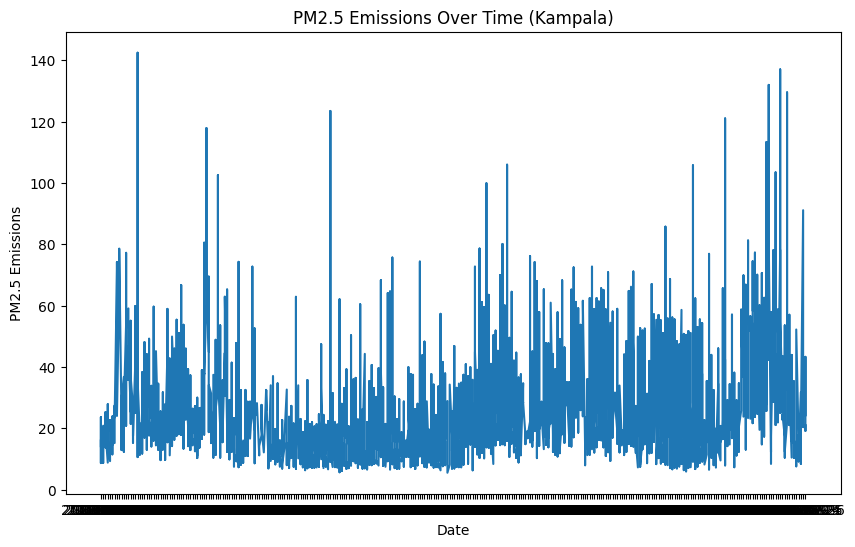

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 804, dtype: object
Nairobi (1478, 80)


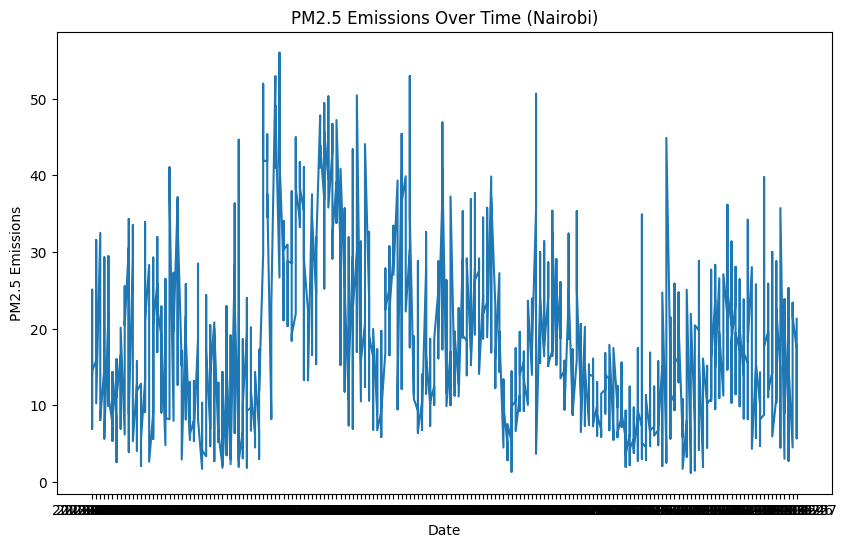

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 804, dtype: object
Lagos (804, 80)


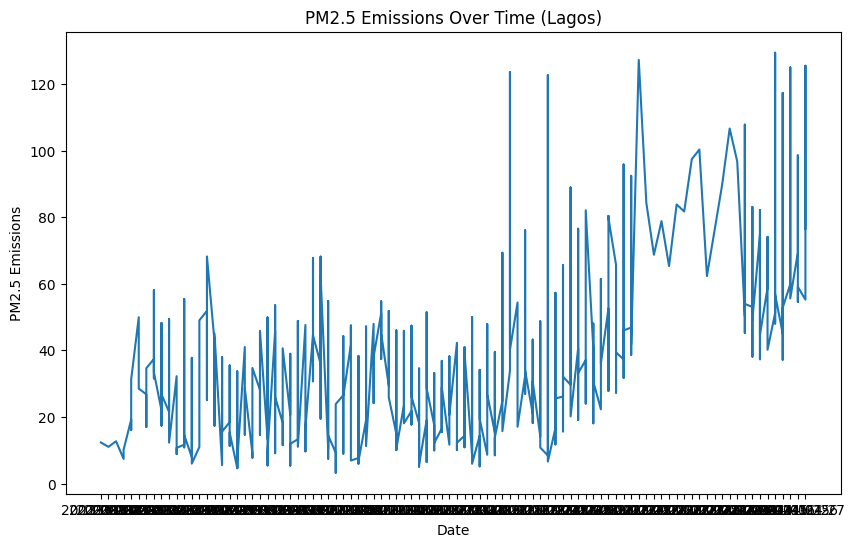

5513    2023-08-02
5514    2023-08-03
5515    2023-08-04
3234    2023-08-05
5516    2023-08-05
           ...    
7293    2024-01-27
997     2024-01-27
1087    2024-01-27
1128    2024-01-27
1144    2024-01-27
Name: date, Length: 804, dtype: object
Bujumbura (123, 80)


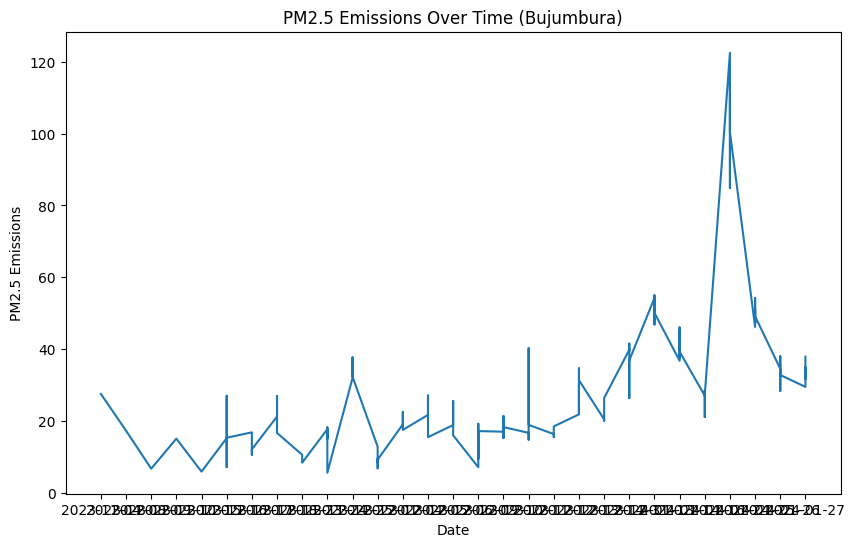

In [515]:
# Plotting emissions over time for each city after removing outliers
plot_pm2_5_emissions_city()

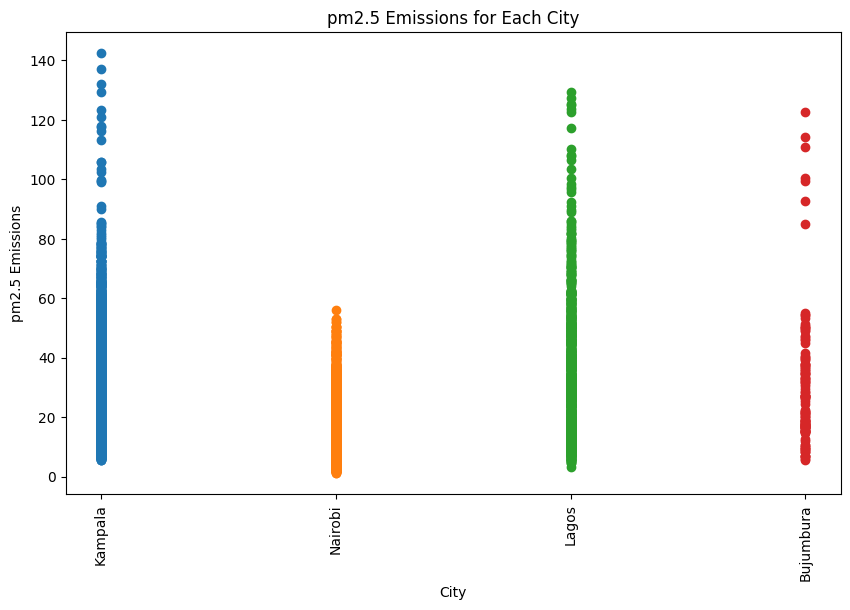

In [516]:
# Scatter plot after processing
plot_pm2_5_emissions_city_scatter()

Seems to be more balanced (Nairobi should have more datapoints at higher pm2.5 emissions but its better than the starting point)